In [1]:
import pandas as pd
import polars as pl
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pl.read_csv('../new_csv/output_dataset.csv', infer_schema_length=None)
df = df.to_pandas()
df = df[df['NumPlayers'] == 2.0]
df = df.dropna(axis=1)
df = df.drop(columns=df.columns[(df == 'NULL').any()])
pl.from_pandas(df).write_csv('output_dataset.csv')

In [3]:
df = pl.read_csv('output_dataset.csv')
df = df.select(df.columns[0:2] + df.columns[6:])
df = df.select([col.name for col in df.select(pl.all().n_unique() > 1) if col.all()])
df = df.group_by('GameRulesetName', 'Id').last()
df = df.to_pandas()

identifier = df[['GameRulesetName', 'Id']]
X = df.drop(columns=['GameRulesetName', 'Id'])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/valid

the elbow is at parameter 30


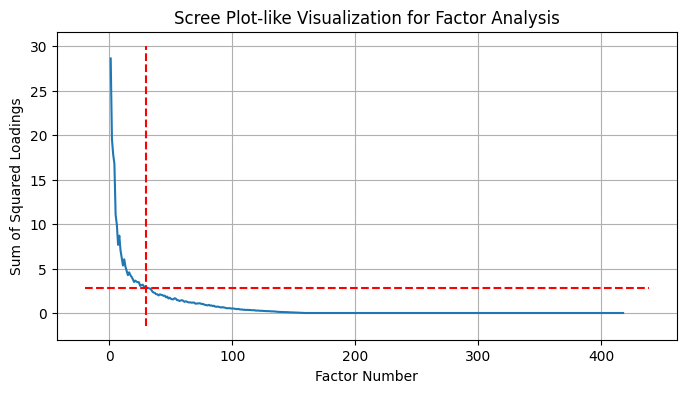

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/valid

In [4]:
from sklearn.decomposition import FactorAnalysis

scaler = StandardScaler()
fa = FactorAnalysis(n_components=len(X))
pipeline = Pipeline([('scaling', scaler), ('fa', fa)])
pipeline.fit_transform(X)

loadings = fa.components_
squared_loadings = np.sum(loadings ** 2, axis=1)

optimal_factors = 30
print(f"the elbow is at parameter {optimal_factors}")

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(squared_loadings) + 1), squared_loadings)
plt.xlabel('Factor Number')
plt.ylabel('Sum of Squared Loadings')
plt.vlines(optimal_factors, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red')
plt.hlines(squared_loadings[optimal_factors], plt.xlim()[0], plt.xlim()[1], linestyles='dashed', colors='red')
plt.title('Scree Plot-like Visualization for Factor Analysis')
plt.grid()
plt.show()

fa_optimal = FactorAnalysis(n_components=optimal_factors)
pipeline = Pipeline([('scaling', scaler), ('fa', fa_optimal)])
x_new = pipeline.fit_transform(X)

In [5]:
print(x_new.shape)
df_new = pd.DataFrame(x_new)
df_new = pd.concat([identifier, df_new], axis=1)
df_new.to_csv('MABGames.csv')
print(df_new)

(1379, 30)
                                        GameRulesetName    Id         0  \
0     Ludus_CoriovalliHaretavl_Switch_Players_-_No_E...  1679 -0.092771   
1                                        Diagonals_2002  1819 -0.017560   
2                              BajrBajr_Medium_Observed  1037 -0.021242   
3                                                 Ngrin  1353 -0.102172   
4                                                Bamboo  1505 -0.026962   
...                                                 ...   ...       ...   
1374                                            Faraday  1531  0.001242   
1375                                       Nei-Pat-Kono    57 -0.083369   
1376                                         Ketch-Dolt   819 -0.001326   
1377                     TokkadilleTokkadille_Described  1076 -0.001326   
1378                              MefuvhaVenda_Observed   187 -0.002945   

             1         2         3         4         5         6         7  \
0    -0.00

In [6]:
import random

random.seed(177013)

expansion = ['ProgressiveHistory', 'UCB1', 'UCB1GRAVE', 'UCB1Tuned']
exploration = ['0.1', '0.6', 'sqrt2']
play_out = ['Random0', 'Random4', 'Random200', 'NST', 'MAST']


def get_environment(games):
    context = []
    game_id = games['Id']
    random_game = random.choice(game_id)
    print(f"random game: {games[games['Id'] == random_game]['GameRulesetName'].to_numpy()[0]}")
    game = games[games['Id'] == random_game]
    game = game[game.columns[2:]]
    game = game.to_numpy().tolist()
    for i in range(len(game)):
        context = context + game[i]

    expansion_onehot = np.zeros(len(expansion))
    expansion_index = random.randrange(len(expansion))
    expansion_onehot[expansion_index] = 1
    context = context + expansion_onehot.tolist()

    exploration_constant = random.choice(exploration)
    context = context + [exploration_constant]

    play_out_onehot = np.zeros(len(play_out))
    play_out_index = random.randrange(len(play_out))
    play_out_onehot[play_out_index] = 1
    context = context + play_out_onehot.tolist()

    print(f"opponent strategy: {expansion[expansion_index]} {exploration_constant} {play_out[play_out_index]}")
    return context


def get_context(game_id, games):
    context = []
    game = games[games['Id'] == game_id]
    game = game[game.columns[2:]]
    game = game.to_numpy().tolist()
    for i in range(len(game)):
        context = context + game[i]

    return context


def get_agent_context(data, agent_num=2):
    context = []
    exploration_var = data.select([f'agent{agent_num}_Exploration']).item()
    expansion_var = data.select([f'agent{agent_num}_Expansion']).item()
    play_out_var = data.select([f'agent{agent_num}_Play-out']).item()

    expansion_onehot = np.zeros(len(expansion))
    expansion_index = expansion.index(expansion_var)
    expansion_onehot[expansion_index] = 1
    context = context + expansion_onehot.tolist()

    exploration_constant = float(exploration_var)
    context = context + [exploration_constant]

    play_out_onehot = np.zeros(len(play_out))
    play_out_index = play_out.index(play_out_var)
    play_out_onehot[play_out_index] = 1
    context = context + play_out_onehot.tolist()

    return context


def get_new_agent_context(exploration_var, expansion_var, play_out_var):
    context = []

    expansion_onehot = np.zeros(len(expansion))
    expansion_index = expansion.index(expansion_var)
    expansion_onehot[expansion_index] = 1
    context = context + expansion_onehot.tolist()

    exploration_constant = float(exploration_var)
    context = context + [exploration_constant]

    play_out_onehot = np.zeros(len(play_out))
    play_out_index = play_out.index(play_out_var)
    play_out_onehot[play_out_index] = 1
    context = context + play_out_onehot.tolist()

    return context

In [7]:
print(get_environment(df_new))


random game: Kharbaga
opponent strategy: ProgressiveHistory 0.6 MAST
[-0.06456673345918264, -0.0076003229656783685, -0.2214444392021463, 0.13725354059347705, 0.0030270987336455464, -0.1445701422770735, 0.0170335887696033, -0.4704528491623498, 0.641004412608343, -0.25371556462547784, 0.19670061025908464, -0.38804737277520235, 1.6804683812438053, 0.010548990226096542, -0.3960285893757869, -0.15601619944319156, -0.25496703214014044, 0.4616788693673176, 1.2527648640898137, 0.15711411765188807, -0.14064283209169542, -0.0745378809424932, -0.2805604744515421, -0.34732341839348185, 0.3284378527113757, -1.8932014303186997, 1.2952364462315713, 1.4181615288329432, -0.026967021458188745, 1.3160369123431517, 1.0, 0.0, 0.0, 0.0, '0.6', 0.0, 0.0, 0.0, 0.0, 1.0]


In [8]:
import math

alpha = 0.01


def softmax(wanted, PI):
    if wanted not in PI:
        raise RuntimeError("desired value is not in the list of possible values")
    denominator = 0
    for p in PI:
        denominator += math.exp(p - max(PI))

    numerator = math.exp(wanted - max(PI))

    return numerator / denominator



In [9]:
df = pl.read_csv('../new_csv/output_dataset.csv', infer_schema_length=None)
df = df.to_pandas()
df = df[df['NumPlayers'] == 2.0]
df = pl.from_pandas(df)
df = df[df.columns[0:12]]
df = df.select(pl.all(), pl.lit(1).alias('counter'))
df = df.filter((pl.col('agent1_AI_type') == 'MCTS') & (pl.col('agent2_AI_type') == 'MCTS'))
df = df.group_by(
    ['GameRulesetName', 'Id', 'agent1_Expansion', 'agent1_Exploration', 'agent1_Play-out', 'agent2_Expansion',
     'agent2_Exploration', 'agent2_Play-out']).agg(pl.col('utility_agent1').sum(), pl.col('utility_agent2').sum(),
                                                   pl.col('counter').sum())
df = df.with_columns((pl.col('utility_agent1') / pl.col('counter')).alias('reward_agent1'))
df = df.with_columns((pl.col('utility_agent2') / pl.col('counter')).alias('reward_agent2'))

df = df.with_columns(
    pl.concat_str([
        pl.col('agent1_Exploration'),
        pl.col('agent1_Expansion'),
        pl.col('agent1_Play-out')
    ],
        separator='')
    .alias('key_agent1')
)

df = df.with_columns(
    pl.concat_str([
        pl.col('agent2_Exploration'),
        pl.col('agent2_Expansion'),
        pl.col('agent2_Play-out')
    ],
        separator='')
    .alias('key_agent2')
)

df.write_csv('game_results.csv')

In [10]:
# from tqdm import tqdm
# 
# np.random.seed(177013)
# n_arms = 60
# alpha = 0.1
# context_length = 50
# 
# weights = np.random.randn(context_length) * 0.01
# ai_mapping = {}
# arm_contexts = {}
# counter = 0
# for exploration_var in exploration:
#     if exploration_var == 'sqrt2':
#         exploration_var = '1.41421356237'
#     for expansion_var in expansion:
#         for play_out_var in play_out:
#             ai_mapping[exploration_var + expansion_var + play_out_var] = counter
#             arm_contexts[exploration_var + expansion_var + play_out_var] = get_new_agent_context(exploration_var,
#                                                                                                  expansion_var,
#                                                                                                  play_out_var)
#             counter += 1
# 
# 
# def policy(weights, arm_context, global_context):
#     context = np.append(arm_context, global_context)
#     wanted = weights.T * context
#     wanted = np.dot(weights.T, context)
#     pi = []
#     for key in arm_contexts:
#         pi.append(np.dot(weights.T, np.append(arm_contexts[key], global_context)))
# 
#     return softmax(wanted, pi)
# 
# 
# for t in tqdm(range(df.shape[0])):
#     arm_context = get_agent_context(df[t], 1)
#     global_context = get_context(df[t].select('Id').item(), df_new)
#     global_context = global_context + get_agent_context(df[t])
#     context = arm_context + global_context
#     context = np.array(context)
#     arm_context = np.array(arm_context)
#     global_context = np.array(global_context)
#     reward = df[t].select(['reward_agent1']).item()
#     sum = 0
#     for key in arm_contexts:
#         sum += policy(weights, arm_contexts[key], global_context) * np.append(arm_contexts[key], global_context)
#     sum = sum * 1 / n_arms
#     weights = weights + alpha * reward * (context - sum)


In [15]:
from tqdm import tqdm


class MAB:
    expansion = ['ProgressiveHistory', 'UCB1', 'UCB1GRAVE', 'UCB1Tuned']
    exploration = ['0.1', '0.6', 'sqrt2']
    play_out = ['Random0', 'Random4', 'Random200', 'NST', 'MAST']
    context_length = 50
    alpha = 0.05

    def __init__(self, n_arms):
        self.weight_change = []
        self.n_arms = n_arms
        self.weights = np.random.randn(self.context_length) * 0.01
        self.arm_contexts = {}
        counter = 0
        for exploration_var in self.exploration:
            if exploration_var == 'sqrt2':
                exploration_var = '1.41421356237'
            for expansion_var in self.expansion:
                for play_out_var in self.play_out:
                    self.arm_contexts[exploration_var + expansion_var + play_out_var] = get_new_agent_context(
                        exploration_var,
                        expansion_var,
                        play_out_var)
                    counter += 1

    def policy(self, weights, arm_context, global_context):
        context = np.append(arm_context, global_context)
        wanted = np.dot(weights.T, context)
        pi = []
        for key in self.arm_contexts:
            pi.append(np.dot(weights.T, np.append(self.arm_contexts[key], global_context)))

        return softmax(wanted, pi)

    def training(self, data, game_data, loops=1):
        self.weight_change = []
        previous_weights = self.weights
        for c in range(loops):
            for t in (pbar := tqdm(range(data.shape[0]))):
                arm_context = get_agent_context(data[t], 1)
                global_context = get_context(data[t].select('Id').item(), game_data)
                global_context = global_context + get_agent_context(data[t])
                context = arm_context + global_context
                context = np.array(context)
                global_context = np.array(global_context)
                reward = data[t].select(['reward_agent1']).item()
                sum = 0
                for key in self.arm_contexts:
                    sum += self.policy(self.weights, self.arm_contexts[key], global_context) * np.append(
                        self.arm_contexts[key],
                        global_context)
                sum = sum * 1 / self.n_arms
                self.weights = self.weights + self.alpha * reward * (context - sum)
                pbar.set_description(
                    f"average difference: {np.mean(np.abs(previous_weights - self.weights))}, loop={c}/{loops - 1}")
                self.weight_change.append(np.mean(np.abs(previous_weights - self.weights)))
                # pbar.set_description(f'difference: {np.sum(np.abs(previous_weights - self.weights))}')
                previous_weights = self.weights

    def get_probability(self, arm_context, global_context):
        return self.policy(self.weights, arm_context, global_context)

    def print_total_prob(self, global_context):
        pi = []
        for key in self.arm_contexts:
            pi.append(np.dot(self.weights.T, np.append(self.arm_contexts[key], global_context)))
        val = 0
        for p in pi:
            val += softmax(p, pi)
        print(val)

In [16]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)
train_loops = 10
agent = MAB(60)
agent.training(train, df_new, train_loops)

average difference: 0.0, loop=9/9: 100%|██████████| 9749/9749 [06:30<00:00, 24.94it/s]                  


Text(0, 0.5, 'Average Weight Difference')

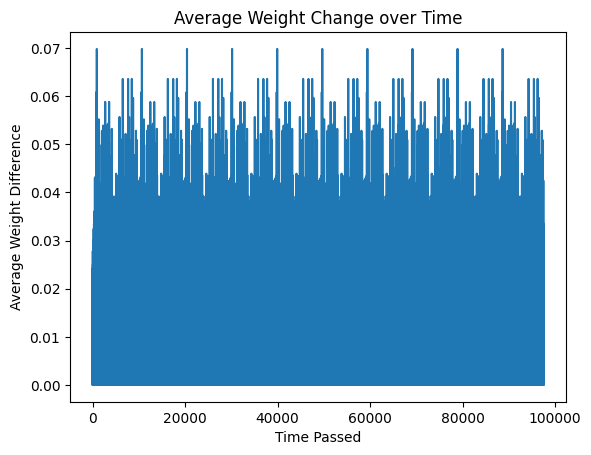

In [18]:
plt.plot(np.arange(len(train) * train_loops), agent.weight_change)
plt.title('Average Weight Change over Time')
plt.xlabel('Time Passed')
plt.ylabel('Average Weight Difference')

policy = 2.6523583886683882e-22: 100%|██████████| 2438/2438 [00:09<00:00, 260.64it/s] 


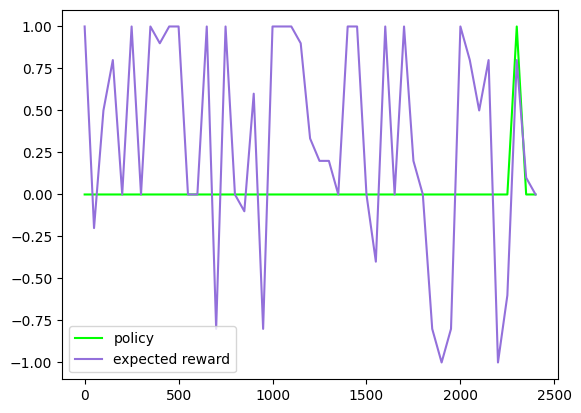

In [19]:
expected_policy = []
expected_reward = []
for t in (pbar := tqdm(range(len(test)))):
    wanted_context = agent.arm_contexts[
        str(test[t].select('agent1_Exploration').item()) + test[t].select('agent1_Expansion').item() + test[t].select(
            'agent1_Play-out').item()]
    # for key in
    opponent_context = get_agent_context(test[t], 2)
    environment_context = get_context(test[t].select('Id').item(), df_new)
    global_context = environment_context + opponent_context
    probability = agent.get_probability(wanted_context, global_context)
    pbar.set_description(f'policy = {probability}')
    expected_policy.append(probability)
    expected_reward.append(test[t].select(['reward_agent1']).item())

nthstep = 50
plt.plot(np.arange(len(test))[::nthstep], expected_policy[::nthstep], color='lime', label='policy')
plt.plot(np.arange(len(test))[::nthstep], expected_reward[::nthstep], color='mediumpurple', label='expected reward')
plt.legend()

mean reward: 0.004580242110284443


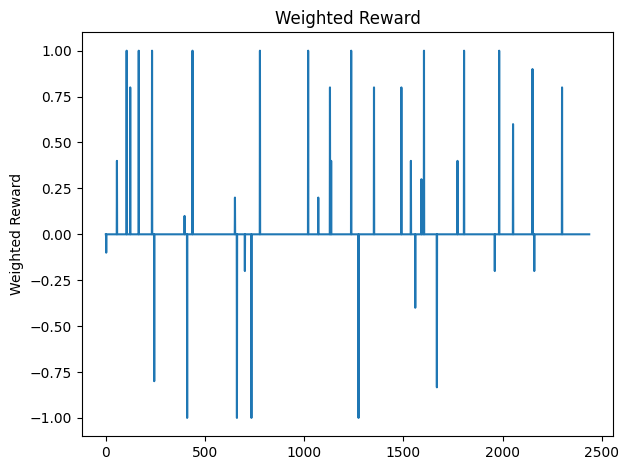

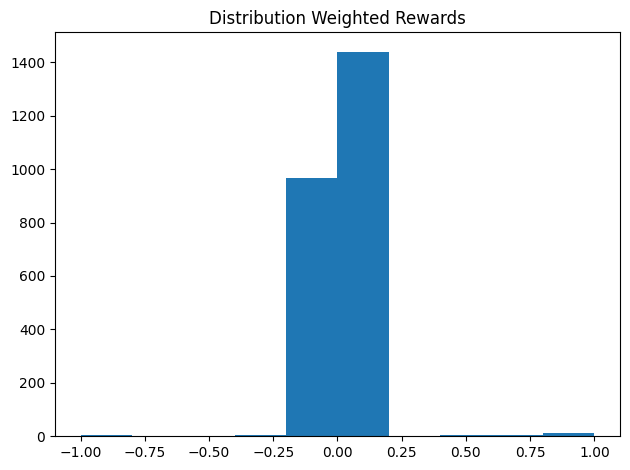

In [20]:
policies = np.array(expected_policy)
rewards = np.array(expected_reward)
print(f"mean reward: {np.mean(policies * rewards)}")
weighted_rewards = policies * rewards

plt.plot(np.arange(len(test)), weighted_rewards)
plt.title('Weighted Reward')
plt.ylabel('Weighted Reward')
plt.tight_layout()
plt.show()
plt.hist(weighted_rewards)
plt.title('Distribution Weighted Rewards')
plt.tight_layout()

In [21]:
print(agent.weights)

[  24.09742627   83.96284831   41.89788064  121.70808033  252.44210334
 -177.30932526  -17.0250534   168.14443611  117.76155179  180.08062039
   -2.97161476   47.88141765  -32.18402474   61.32860381    8.20990316
  -10.67326246   27.39622016  -29.14133522   48.81325185   16.74170786
   36.99309682   77.34517565  -70.57087241  108.88000657   -2.82023343
  -66.98865395   33.70016953   90.56879096  -82.60891949 -173.79742906
   64.72691271   31.36643122  -38.38197991   -3.97632316  -47.47847975
   90.36254859   26.76675025   18.82511918   -0.88887044  -23.49974511
  107.05520159   58.34282734   98.01426717    8.19717629  148.09152287
  281.30844674  109.13224263  -42.51213574  -21.80398751  -54.47351004]
